In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from google.cloud import storage
from pyspark.sql import functions as F
import os
import io
from datetime import datetime
from tqdm import tqdm

In [2]:
spark = SparkSession.builder.appName('bigdata_taxi').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.driver.port', '43481'),
 ('spark.driver.host',
  'hub-hub-msca-bdp-dphub-student-dharmi-m.c.msca-bdp-student-ap.internal'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.eventLog.dir',
  'gs://dataproc-temp-us-central1-635155370842-uzamlpgc/67aee9a1-6ac9-4d86-a9d9-8e05824dfd30/spark-job-history'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.driver.appUIAddress',
  'http://hub-hub-msca-bdp-dphub-student-dharmi-m.c.msca-bdp-student-ap.internal:46793'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.ui.proxyBase', '/proxy/application_1677978948583_0005'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spark.app.id}'),
 ('spark.executor.me

In [3]:
# bucket_name = 'msca-bdp-student-gcs'
# storage_client = storage.Client()
# from_date = datetime.strptime('2022-10-01','%Y-%m-%d')
# to_date = datetime.strptime('2022-10-30','%Y-%m-%d')
# folder_name = 'Group8_Project_Data'
# for blob in tqdm(storage_client.list_blobs(bucket_name, prefix = folder_name)):
#     if str(blob.name).split(".")[-1] == 'parquet':
#         file_month = ''.join(list(filter(str.isdigit, blob.name))[1:])
#         if datetime.strptime(file_month, '%Y%m') >= from_date and datetime.strptime(file_month, '%Y%m') <= to_date:
#             if datetime.strptime(file_month, '%Y%m') == from_date:
#                 df = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
#             else:
#                 df = df.union(spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True))        
                
# location_mapping = spark.read.csv(f'gs://{bucket_name}/{folder_name}/tlc_trip_record_yellow_taxi/taxi_zone_lookup.csv', inferSchema = True, header = True)

In [4]:
# df.printSchema()

In [5]:
# df.groupby(F.to_date(df.tpep_pickup_datetime).alias('pickup_date')) \
#   .count() \
#   .sort("count") \
#   .orderBy(["count"], ascending=[0]) \
#   .toPandas()

In [6]:
bucket_name = 'msca-bdp-student-gcs'
storage_client = storage.Client()
from_date = datetime.strptime('2012-11-01','%Y-%m-%d')
to_date = datetime.strptime('2022-10-31','%Y-%m-%d')
folder_name = 'Group8_Project_Data'
for blob in tqdm(storage_client.list_blobs(bucket_name, prefix = folder_name)):
    if str(blob.name).split(".")[-1] == 'parquet':
        file_month = ''.join(list(filter(str.isdigit, blob.name))[1:])
        if datetime.strptime(file_month, '%Y%m') >= from_date and datetime.strptime(file_month, '%Y%m') <= to_date:
            if datetime.strptime(file_month, '%Y%m') == from_date:
                df = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
            else:
                df1 = spark.read.parquet(f'gs://{bucket_name}/{blob.name}', inferSchema=True, header=True)
                df1 = df1.filter(df1.tpep_pickup_datetime >= '2012-11-01')
                df1 = df1.filter(df1.tpep_pickup_datetime <= '2022-10-31')
                df = df.union(df1)
                
location_mapping = spark.read.csv(f'gs://{bucket_name}/{folder_name}/tlc_trip_record_yellow_taxi/taxi_zone_lookup.csv', inferSchema = True, header = True)

170it [00:56,  3.03it/s]                                                        


In [7]:
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [8]:
location_mapping.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [9]:
new_column_name_list = list(map(lambda x: 'PU' + x , location_mapping.columns))
location_mapping_pu = location_mapping.toDF(*new_column_name_list)

df = df.join(location_mapping_pu,df.PULocationID == location_mapping_pu.PULocationID,"left").drop('PULocationID','LocationID')

In [10]:
new_column_name_list = list(map(lambda x: 'DO' + x , location_mapping.columns))
location_mapping_do = location_mapping.toDF(*new_column_name_list)

df = df.join(location_mapping_do,df.DOLocationID == location_mapping_do.DOLocationID,"left").drop('DOLocationID','LocationID','PULocationID')


In [11]:
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- PUZone: string (nullable = true)
 |-- PUservice_zone: string (nullable = true)
 |-- DOBorough: string (nullable = true)
 |-- DOZone: string (nullable = true)
 |-- DOservice_zone

In [13]:
from pyspark.sql.functions import date_format
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F

# aggregate the number of trips by pickup and drop-off boroughs
df = df.withColumn('pickup_year', date_format('tpep_pickup_datetime', 'yyyy'))
df1 = df.filter((df.pickup_year >= 2022) & (df.pickup_year <= 2022))
agg_df = df1.groupBy('PUBorough', 'DOBorough').agg(F.count('*').alias('num_trips')).orderBy('num_trips', ascending=False)


23/03/05 23:05:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1208.4 KiB


<AxesSubplot:xlabel='DOBorough', ylabel='PUBorough'>

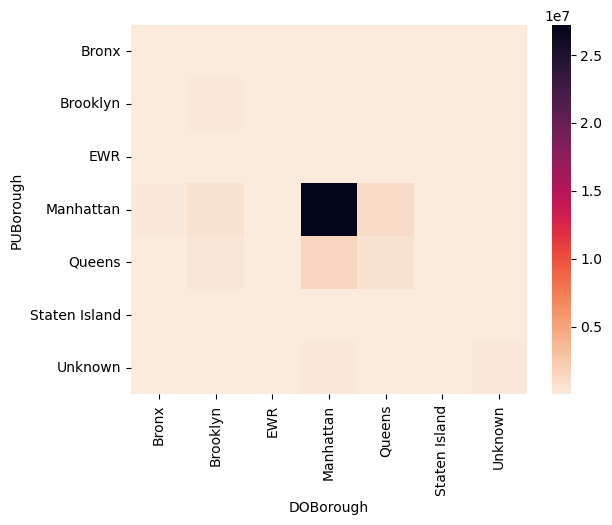

In [14]:
# convert Spark DataFrame to Pandas DataFrame
df_pd = agg_df.toPandas()

# create a pivot table with PUBorough as rows, DOBorough as columns, and num_trips as values
pivot_table = pd.pivot_table(df_pd, values='num_trips', index='PUBorough', columns='DOBorough')

# create the heatmap using seaborn
sns.heatmap(pivot_table, cmap='rocket_r')

In [15]:
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F

# aggregate the number of trips by pickup and drop-off boroughs
# df = df.withColumn('pickup_year', date_format('tpep_pickup_datetime', 'yyyy'))
df2 = df.filter((df.pickup_year >= 2012) & (df.pickup_year <= 2015))
agg_df1 = df2.groupBy('PUBorough', 'DOBorough').agg(F.count('*').alias('num_trips')).orderBy('num_trips', ascending=False)


23/03/05 23:07:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1208.3 KiB


<AxesSubplot:xlabel='DOBorough', ylabel='PUBorough'>

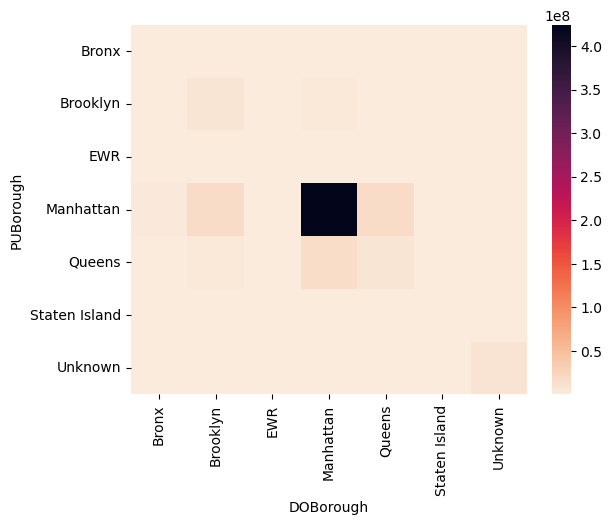

In [16]:
# convert Spark DataFrame to Pandas DataFrame
df_pd = agg_df1.toPandas()

# create a pivot table with PUBorough as rows, DOBorough as columns, and num_trips as values
pivot_table = pd.pivot_table(df_pd, values='num_trips', index='PUBorough', columns='DOBorough')

# create the heatmap using seaborn
sns.heatmap(pivot_table, cmap='rocket_r')

In [19]:
# # Convert pickup_datetime column to date
df = df.withColumn('pickup_month_year', date_format('tpep_pickup_datetime', 'yyyy-MM'))

# Group data by pickup_month_year and aggregate number of trips and average fare price for each month
agg_df2 = df.groupBy('pickup_month_year').agg(F.count('*').alias('num_trips'), 
                                             F.avg('fare_amount').alias('avg_fare'),
                                            F.avg('trip_distance').alias('avg_dist')).orderBy('pickup_month_year')


In [20]:
agg_df2.printSchema()

root
 |-- pickup_month_year: string (nullable = true)
 |-- num_trips: long (nullable = false)
 |-- avg_fare: double (nullable = true)
 |-- avg_dist: double (nullable = true)



In [21]:
agg_df2.show(5)

23/03/05 23:13:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1125.9 KiB


+-----------------+---------+------------------+------------------+
|pickup_month_year|num_trips|          avg_fare|          avg_dist|
+-----------------+---------+------------------+------------------+
|          2012-11| 13776030|12.270137514944473| 2.869022110869554|
|          2012-12| 14696610|12.313947279678867|2.8541207428107427|
|          2013-01| 14776617|11.664721908945765| 2.770975573096631|
|          2013-02| 13990176|11.713748805590377|2.7416122234634632|
|          2013-03| 15749228|12.035117579731597|2.8414825431454034|
+-----------------+---------+------------------+------------------+
only showing top 5 rows



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pd = agg_df2.toPandas()

# create a scatter plot
sns.scatterplot(x='avg_dist', y='avg_fare', data=df_pd)

# set the labels and title
plt.xlabel('Average Distance (miles)')
plt.ylabel('Average Fare ($)')
plt.title('Average Fare vs Average Distance')

# show the plot
plt.show()


In [22]:
# Convert pickup_datetime column to date
# df = df.withColumn('pickup_month_year', date_format('tpep_pickup_datetime', 'yyyy-MM'))

# Group data by pickup_month_year and aggregate number of trips and average fare price for each month
agg_df3 = df.groupBy('pickup_month_year').agg(F.count('*').alias('num_trips'), F.avg('fare_amount').alias('avg_fare')).orderBy('pickup_month_year')


In [ ]:
num_rows = agg_df3.count()
num_cols = len(agg_df3.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 120
Number of columns: 3


In [ ]:
from pyspark.sql.functions import col

df_airport = df.filter(col('airport_fee') > 0)

In [ ]:
# Convert pickup_datetime column to date
df_airport = df_airport.withColumn('pickup_month_year', date_format('tpep_pickup_datetime', 'yyyy-MM'))

# Group data by pickup_month_year and aggregate number of trips and average fare price for each month
air_agg_df = df_airport.groupBy('pickup_month_year').agg(F.count('*').alias('num_airport_trips'), F.avg('fare_amount').alias('avg_airport_fare')).orderBy('pickup_month_year')


23/03/05 23:19:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1046.0 KiB
/tmp/ipykernel_27108/1521801670.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_pd.pickup_month_year, rotation=90)


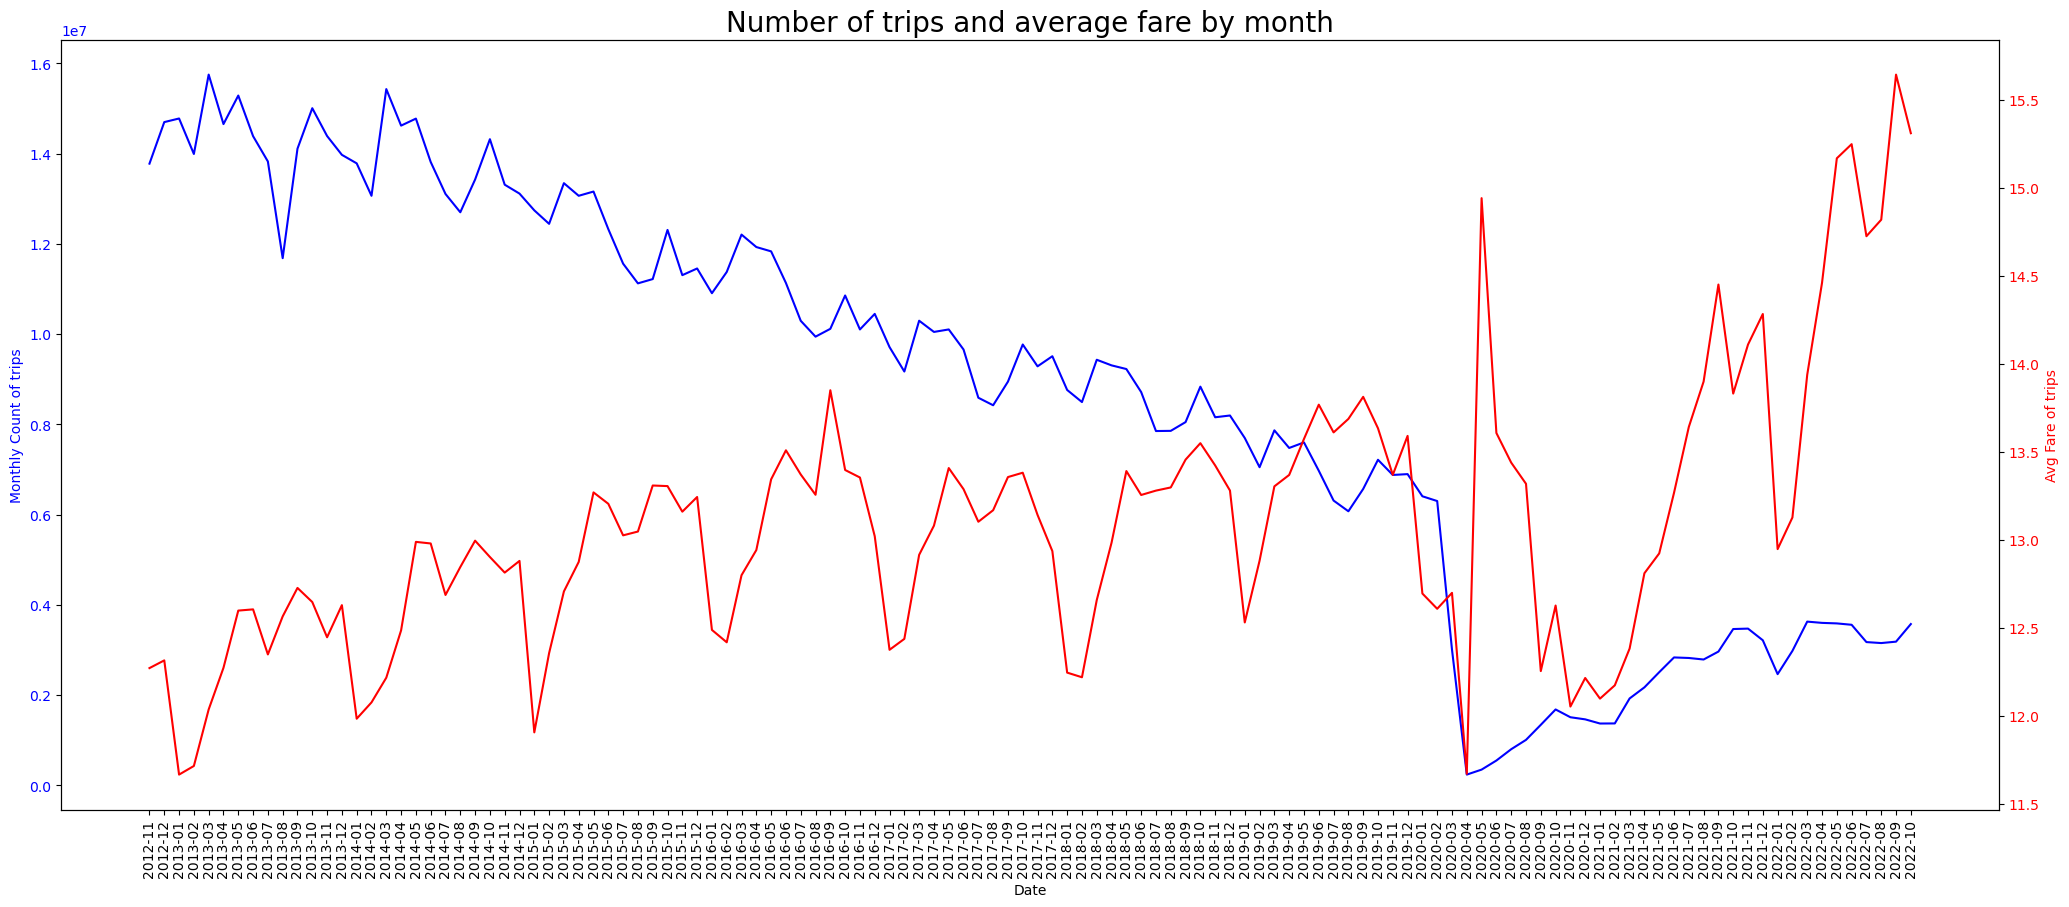

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pd = agg_df3.toPandas()

# create two separate subplots
fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twinx()

# plot the first line on the first axis
sns.lineplot(x=df_pd.pickup_month_year, y=df_pd.num_trips, ax=ax1, color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Count of trips', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# plot the second line on the second axis
sns.lineplot(x=df_pd.pickup_month_year, y=df_pd.avg_fare, ax=ax2, color='r')
ax2.set_ylabel('Avg Fare of trips', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# rotate xtick labels by 90 degrees
ax1.set_xticklabels(df_pd.pickup_month_year, rotation=90)

# set the title of the chart
plt.title('Number of trips and average fare by month', fontsize=20)

# show the chart
plt.show()


23/03/05 23:22:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1185.4 KiB
/tmp/ipykernel_27108/2412703196.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_pd.pickup_month_year, rotation=90)


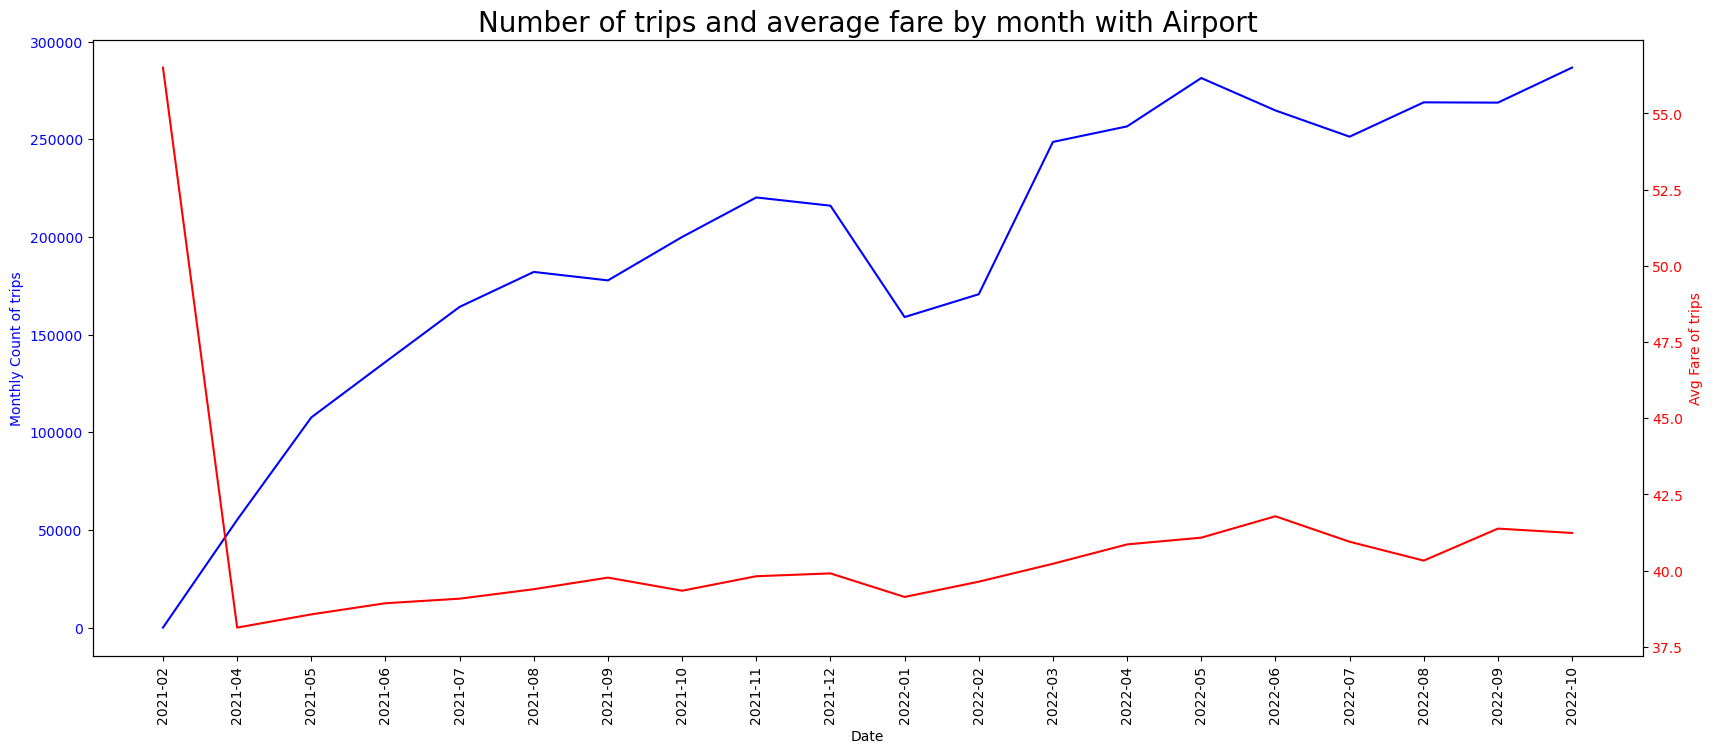

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pd = air_agg_df.toPandas()

# create two separate subplots
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# plot the first line on the first axis
sns.lineplot(x=df_pd.pickup_month_year, y=df_pd.num_airport_trips, ax=ax1, color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Count of trips', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# plot the second line on the second axis
sns.lineplot(x=df_pd.pickup_month_year, y=df_pd.avg_airport_fare, ax=ax2, color='r')
ax2.set_ylabel('Avg Fare of trips', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# rotate xtick labels by 90 degrees
ax1.set_xticklabels(df_pd.pickup_month_year, rotation=90)

# set the title of the chart
plt.title('Number of trips and average fare by month with Airport', fontsize=20)

# show the chart
plt.show()
